## Imports

In [1]:
# import keras
import numpy as np

import time

import os

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras.layers as tfl

# import misc

import pandas as pd

import datetime

import glob

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, Input, Conv1D, MaxPooling1D, Flatten, \
                                    Masking, LSTM, Softmax, Multiply, Layer, Concatenate, Lambda, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# from keras.utils import np_utils
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.datasets import load_files
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
# import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn.model_selection import train_test_split

import tensorly as tl
from tensorly.decomposition import tucker

In [2]:
# Set up imports & packages.

tl.set_backend('tensorflow')  # Use TensorFlow tensors instead of NumPy

## Declare Sub-Models

In [3]:
# Default 16.
feature_vector_size = 2

### Visual Embedder (VGG-16)

In [4]:
def build_visual_embedder():
    # Load the VGG16 model without the top layers
    visual_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model to retain pretrained weights during training
    visual_base_model.trainable = False

    # Add a top for 3-way classification
    x = visual_base_model.output
    x = GlobalAveragePooling2D()(x)  # Global Average Pooling layer
    x = Dropout(0.1)(x)              # Dropout for regularization
    x = Dense(512, activation='relu')(x)  # Fully connected layer
    x = Dropout(0.1)(x)              # Dropout for regularization
    x = Dense(512, activation='relu')(x)  # Fully connected layer
    x = Dropout(0.1)(x)              # Dropout for regularization
    x = Dense(256, activation='relu')(x)  # Fully connected layer
    x = Dropout(0.1)(x)              # Dropout for regularization

    visual_base_features = Dense(feature_vector_size, activation='relu')(x) 

    # Define the final model
    visual_model = Model(inputs=visual_base_model.input, outputs=visual_base_features, name="VisualEmbedder")
    return visual_model

### Demographic Embedder

In [5]:
def build_demographics_embedder():
    # Input layer for demographics data
    input_layer = Input(shape=(6, ), name="demographics_input")

    x = Dense(16, activation='relu')(input_layer)
    x = Dropout(0.1)(x)
    x = Dense(4, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    # Classification head
    demographics_base_features = Dense(feature_vector_size, activation='relu')(x)
    
    # Define the model
    demographics_model = Model(inputs=input_layer, outputs=demographics_base_features, name="DemographicsEmbedder")
    return demographics_model

### Time-Series Embedder

In [6]:
max_seq_length = 6

In [7]:
def build_time_embedder():
    # Input layer for time series data (4 input variables)
    time_series_input = Input(shape=(max_seq_length, 4), name="time_series_input")
    masked_input = Masking(mask_value=0.0)(time_series_input)

    # Use the last hidden state
    x = LSTM(32, return_sequences=False)(masked_input)

    # Dense layer to create time series output
    time_base_features = Dense(feature_vector_size, activation="relu")(x)
    
    # Define the model
    time_model = Model(inputs=time_series_input, outputs=time_base_features, name="TimeSeriesEmbedder")
    return time_model

## Joint Model

In [8]:
visual_dim = feature_vector_size
demographics_dim = feature_vector_size
time_dim = feature_vector_size

# Tensor Fusion Layer
def tensor_fusion_layer(inputs):
    """
    Tensor fusion using Kronecker product via `tf.einsum`.
    Adds a 1 to each input tensor for core (0,0,0) alignment.
    """
    visual, demographics, time_series = inputs

    # Add a "1" to the feature vectors
    visual_h = tf.concat([tf.ones((tf.shape(visual)[0], 1)), visual], axis=1)
    demographics_h = tf.concat([tf.ones((tf.shape(demographics)[0], 1)), demographics], axis=1)
    time_series_h = tf.concat([tf.ones((tf.shape(time_series)[0], 1)), time_series], axis=1)

    # Perform Kronecker product using tf.einsum
    outer_xy = tf.einsum('bi,bj->bij', demographics_h, time_series_h)  # Shape: (batch_size, d_dim, t_dim)
    outer_xyz = tf.einsum('bij,bk->bijk', outer_xy, visual_h)  # Shape: (batch_size, d_dim, t_dim, v_dim)

    # core, factors = tucker(outer_xyz, rank=(8,8,8))

    # # Flatten the fused tensor
    fused_tensor = tf.reshape(outer_xyz, (tf.shape(outer_xyz)[0], -1))  # Shape: (batch_size, d_dim * t_dim * v_dim)

    return fused_tensor #outer_xyz

In [9]:
# Visual embedder
visual_embedder = build_visual_embedder()

# Demographics embedder
demographics_embedder = build_demographics_embedder()

# Time Series Embedder
time_embedder = build_time_embedder()

# Outputs from embedders
visual_features = visual_embedder.output
demographics_features = demographics_embedder.output
time_features = time_embedder.output

# Output shape of the fused tensor
fused_tensor_shape = (None, (visual_dim + 1) * (demographics_dim + 1) * (time_dim + 1))

# Apply Tensor Fusion
fused_features = Lambda(tensor_fusion_layer, output_shape=fused_tensor_shape)([visual_features, demographics_features, time_features])

# Add final classification layers
x = Dense(128, activation='relu')(fused_features)
x = Dense(64, activation='relu')(x)
final_output = Dense(3, activation='softmax', name="final_output")(x)

# Define the combined model
combined_model = Model(inputs=[visual_embedder.input, demographics_embedder.input, time_embedder.input], 
                       outputs=final_output, name="CombinedModel")

#### Joint-Model Structure

In [10]:
combined_model.summary()

Model: "CombinedModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 15,388,869 (58.70 MB)

 Trainable params: 674,181 (2.57 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Train Joint-Model

#### Load Data

In [11]:
# Mapping for string labels to integers
label_mapping = {"CN": 0, "MCI": 1, "Dementia": 2}

In [12]:
manifest = pd.read_csv("./AD_Patient_Manifest.csv")
manifest

,PTID,path
0,002_S_0295,patients_csv\002_S_0295.pkl
1,002_S_0413,patients_csv\002_S_0413.pkl
2,002_S_0619,patients_csv\002_S_0619.pkl
3,002_S_0685,patients_csv\002_S_0685.pkl
4,002_S_0729,patients_csv\002_S_0729.pkl
...,...,...
377,137_S_0994,patients_csv\137_S_0994.pkl
378,137_S_1041,patients_csv\137_S_1041.pkl
379,137_S_1414,patients_csv\137_S_1414.pkl
380,941_S_1194,patients_csv\941_S_1194.pkl


In [13]:

patient_df = pd.read_pickle("patients_csv/002_S_0295.pkl")
patient_df


,RID,PTID,DX,MMSE,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,...,ADAS13,ADASQ4,Years_bl,EXAMDATE,image_path,DX_encoded,PTGENDER_encoded,PTETHCAT_encoded,PTRACCAT_encoded,PTMARRY_encoded
0,295,002_S_0295,CN,28.0,84.8,Male,18,Not Hisp/Latino,White,Married,...,4.00,1.0,0.00000,2006-05-09,/home/mason/ADNI_Dataset/ADNI_IMG_32.5%_x/I118...,0,1,1,2,1
1,295,002_S_0295,CN,28.0,84.8,Male,18,Not Hisp/Latino,White,Married,...,6.33,1.0,0.48460,2006-11-02,/home/mason/ADNI_Dataset/ADNI_IMG_32.5%_x/I118...,0,1,1,2,1
2,295,002_S_0295,CN,30.0,84.8,Male,18,Not Hisp/Latino,White,Married,...,5.67,1.0,1.04312,2007-05-25,/home/mason/ADNI_Dataset/ADNI_IMG_32.5%_x/I640...,0,1,1,2,1
3,295,002_S_0295,CN,29.0,84.8,Male,18,Not Hisp/Latino,White,Married,...,5.67,2.0,2.23956,2008-08-04,/home/mason/ADNI_Dataset/ADNI_IMG_32.5%_x/I123...,0,1,1,2,1
4,295,002_S_0295,CN,28.0,84.8,Male,18,Not Hisp/Latino,White,Married,...,6.67,3.0,2.99521,2009-05-07,/home/mason/ADNI_Dataset/ADNI_IMG_32.5%_x/I150...,0,1,1,2,1


In [14]:
# Load all data into memory. Not elegant, but works.
def load_all_data(manifest, target_size=(224, 224), demographic_columns=None, time_series_columns=None, label_mapping=None):
    image_data = []
    demographics_data = []
    time_series_data = []
    labels = []
    label_mapping = label_mapping or {}

    for _, row in manifest.iterrows():
        patient_path = row["path"]
        patient_df = pd.read_pickle(patient_path)

        # ✅ [중요] 경로 변경
        patient_df['image_path'] = patient_df['image_path'].apply(
            lambda x: x.replace("/home/mason/ADNI_Dataset/", "../ADNI_Dataset/")
        )

        # Load image data
        image_paths = [patient_df['image_path'].iloc[0]]
        for path in image_paths:
            # print(path)
            img = load_img(path, target_size=target_size)
            img_array = img_to_array(img)
            img_array = preprocess_input(img_array)
            image_data.append(img_array)

        # Process demographics data
        if demographic_columns is None:
            raise ValueError("Please specify the demographics columns.")
        
        # Get first row of demographic data (since it doesn't change over time)
        demographics = patient_df[demographic_columns].iloc[0]
        demographics = demographics.values.astype(np.float32)  # Convert to NumPy array
        demographics_data.append(demographics)

        # Process time series data
        if time_series_columns is None:
            raise ValueError("Please specify the time series columns.")
        
        # Extract the relevant time series columns
        time_series = patient_df[time_series_columns].values  # Extract as NumPy array

        # Truncate or pad to max_seq_length
        if len(time_series) > max_seq_length:
            time_series = time_series[:max_seq_length, :]
        elif len(time_series) < max_seq_length:
            padding = np.zeros((max_seq_length - len(time_series), len(time_series_columns)))
            time_series = np.vstack([time_series, padding])
        time_series_data.append(time_series)

        # Load labels
        label_str = patient_df['DX'].iloc[0]
        label_int = label_mapping[label_str]
        labels.append(label_int)

    # Convert to numpy arrays
    image_data = np.array(image_data, dtype=np.float32)
    demographics_data = np.array(demographics_data, dtype=np.float32)
    time_series_data = np.array(time_series_data, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)

    return image_data, demographics_data, time_series_data, labels

In [15]:
# Demographic variables to extract
demographic_columns = ['AGE', 'PTEDUCAT', 'PTGENDER_encoded', 
                        'PTETHCAT_encoded', 'PTRACCAT_encoded', 'PTMARRY_encoded']
# Time series variables to extract
time_series_columns = ['Years_bl', 'ADAS11', 'ADAS13', 'ADASQ4']

# Load all data into memory
image_data, demographics_data, time_series_data, labels = load_all_data(manifest, target_size=(224, 224), demographic_columns=demographic_columns, 
                                                      time_series_columns=time_series_columns, label_mapping=label_mapping)

# Split the data
test_size = 0.2  # 20% of the data for testing

(image_train, image_test,
 demographics_train, demographics_test,
 time_train, time_test,
 labels_train, labels_test) = train_test_split(
    image_data, demographics_data, time_series_data, labels, test_size=test_size, random_state=42, stratify=labels
)

In [16]:
# (1) Extract survival time from time step 0, feature 0 (Years_bl)
survival_time_train = time_train[:, 0, 0]
survival_time_test = time_test[:, 0, 0]

# (2) Clip event values to be 0 or 1
event_train = np.clip(np.array(labels_train).astype(np.float32).reshape(-1,), 0, 1)
event_test = np.clip(np.array(labels_test).astype(np.float32).reshape(-1,), 0, 1)

# (3) Stack into (N, 2) for Cox loss
labels_train = np.stack([survival_time_train, event_train], axis=1)
labels_test = np.stack([survival_time_test, event_test], axis=1)

print("✅ Final labels_train shape:", labels_train.shape)
print("✅ Final labels_train sample:", labels_train[:5])


✅ Final labels_train shape: (305, 2)
✅ Final labels_train sample: [[0. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 0.]]


In [17]:
batch_size = 64

# # Create training dataset
# train_dataset = tf.data.Dataset.from_tensor_slices(((image_train, demographics_train, time_train), labels_train))
# train_dataset = train_dataset.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)
#
# # Create testing (validation) dataset
# test_dataset = tf.data.Dataset.from_tensor_slices(((image_test, demographics_test, time_test), labels_test))
# test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_dataset = tf.data.Dataset.from_tensor_slices(((image_train, demographics_train, time_train), labels_train))
train_dataset = train_dataset.shuffle(100).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(((image_test, demographics_test, time_test), labels_test))
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)



In [18]:
print(f"Image train shape: {image_train.shape}")
print(f"Demographics train shape: {demographics_train.shape}")
print(f"Time train shape: {time_train.shape}")
print(f"Labels train shape: {labels_train.shape}")

Image train shape: (305, 224, 224, 3)
Demographics train shape: (305, 6)
Time train shape: (305, 6, 4)
Labels train shape: (305, 2)



#### Train the Model

In [19]:
import tensorflow.keras.backend as K

def cox_ph_loss(y_true, y_pred):
    y_pred = tf.reshape(y_pred, [-1])
    time = y_true[:, 0]
    event = y_true[:, 1]

    order = tf.argsort(time, direction='DESCENDING')
    time = tf.gather(time, order)
    event = tf.gather(event, order)
    y_pred = tf.gather(y_pred, order)

    exp_pred = tf.exp(y_pred)
    log_cum_hazard = tf.math.log(tf.cumsum(exp_pred))

    diff = y_pred - log_cum_hazard
    observed_loss = tf.boolean_mask(diff, tf.equal(event, 1))
    neg_log_likelihood = -K.mean(observed_loss)

    return neg_log_likelihood


In [20]:
combined_model.compile(
    optimizer=Adam(learning_rate=0.0001, clipnorm=1.0),
    loss=cox_ph_loss,
    run_eagerly=False
)


In [21]:
print("Model inputs:", combined_model.input)

Model inputs: [<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=keras_tensor>, <KerasTensor shape=(None, 6), dtype=float32, sparse=False, name=demographics_input>, <KerasTensor shape=(None, 6, 4), dtype=float32, sparse=False, name=time_series_input>]


In [22]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


In [23]:
import tensorflow as tf

print("✅ TensorFlow version:", tf.__version__)
print("✅ TensorFlow path:", tf.__path__)
print("✅ CUDA built:", tf.test.is_built_with_cuda())
print("✅ Available GPUs:", tf.config.list_physical_devices('GPU'))

import tensorflow as tf

print("🧠 Using GPU:", tf.config.list_physical_devices('GPU'))

with tf.device('/GPU:0'):
    a = tf.random.normal([1000, 1000])
    b = tf.random.normal([1000, 1000])
    c = tf.matmul(a, b)
    print("✅ Matrix multiplication completed.")


✅ TensorFlow version: 2.18.0
✅ TensorFlow path: ['C:\\Users\\myh04\\miniconda3\\envs\\tf_gpu_env\\lib\\site-packages\\keras\\api\\_v2', 'C:\\Users\\myh04\\miniconda3\\envs\\tf_gpu_env\\lib\\site-packages\\keras\\_tf_keras', 'C:\\Users\\myh04\\miniconda3\\envs\\tf_gpu_env\\lib\\site-packages\\tensorflow', 'C:\\Users\\myh04\\miniconda3\\envs\\tf_gpu_env\\lib\\site-packages\\tensorflow\\_api\\v2']
✅ CUDA built: False
✅ Available GPUs: []
🧠 Using GPU: []
✅ Matrix multiplication completed.


In [24]:
from tqdm.keras import TqdmCallback

history = combined_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=50,
    callbacks=[
        early_stopping,
        TqdmCallback(verbose=1)
    ],
    verbose=0
)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

C:\Users\myh04\miniconda3\envs\tf_gpu_env\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'demographics_input', 'time_series_input']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


Restoring model weights from the end of the best epoch: 43.


#### Visualize Training Performance

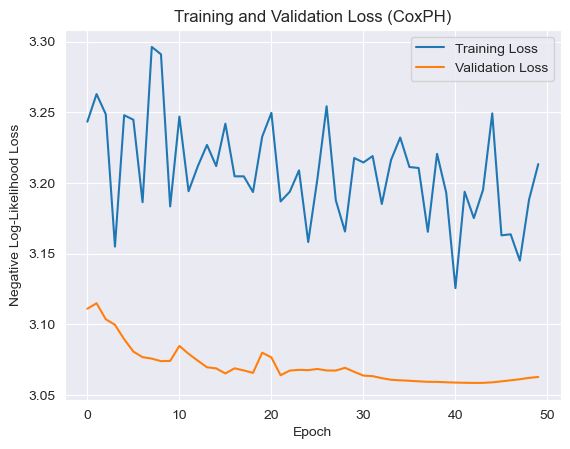

In [25]:
import matplotlib.pyplot as plt

# Get training and validation loss
train_loss = history.history['loss']
val_loss = history.history.get('val_loss')  # 없으면 None

# Plot loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
if val_loss:
    plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Negative Log-Likelihood Loss')
plt.title('Training and Validation Loss (CoxPH)')
plt.legend()
plt.grid(True)
plt.show()


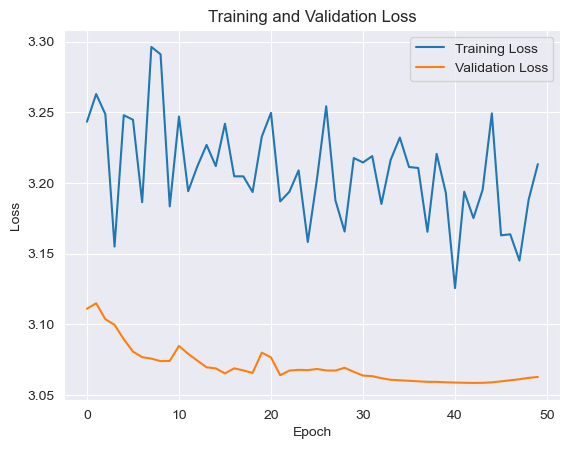

In [26]:
# Plot training and validation loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [27]:
# Get the final accuracy and loss for the last epoch
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# Print the final accuracy and loss
print("Final Training Accuracy:", final_train_acc)
print("Final Validation Accuracy:", final_val_acc)
print("Final Training Loss:", final_train_loss)
print("Final Validation Loss:", final_val_loss)

KeyError: 'accuracy'

In [ ]:
# Save the entire model as a `.keras` zip archive.
combined_model.save('MTFN_32Rank.keras')

## Visualizations

#### VGG Feature Maps

In [ ]:
iterator = iter(train_dataset)
first_element, label = next(iterator)

In [ ]:
# Load the existing model (if needed)
# combined_model = tf.keras.models.load_model('AD_Multimodal_Model.keras')

# Choose a layer to visualize (e.g., the output of the first convolutional layer)
layer_name = 'block1_conv1'
intermediate_layer_model = tf.keras.models.Model(inputs=combined_model.input, outputs=combined_model.get_layer(layer_name).output)

# Load and preprocess an image
def load_and_preprocess_image(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=(224, 224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    return img_array

image_path = '../ADNI_Dataset/ADNI_IMG_32.5%_x/I124297.png'
preprocessed_image = load_and_preprocess_image(image_path)

# Get the feature maps
feature_maps = intermediate_layer_model.predict(first_element)

# Visualize the feature maps
def visualize_feature_maps(feature_maps):
    num_feature_maps = feature_maps.shape[-1]
    
    # Determine the layout for subplots (adjust as needed)
    grid_size = int(np.ceil(np.sqrt(num_feature_maps)))
    
    plt.figure(figsize=(12, 12))
    for i in range(num_feature_maps):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(feature_maps[0, :, :, i], cmap='gray')
    plt.show()

visualize_feature_maps(feature_maps)


In [ ]:
plt.imshow(feature_maps[0, :, :, 1], cmap='CMRmap')
# plt.savefig('VGG_Feature_Map.png', dpi=300)  # Save as PNG with 300 DPI

ValueError: 'green' is not a valid value for cmap; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'